In [ ]:
LOAD = True

In [ ]:
import os
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    COLAB = True
    CFG_FILE = 'config/my_yolo3_cfg5.txt'
    SAVEFILE = os.path.join('/content/gdrive/My Drive/Colab Notebooks/', 'yolo_my5.pt')
    LOADFILE = os.path.join('/content/gdrive/My Drive/Colab Notebooks/', 'yolo_my5.pt')
except ModuleNotFoundError:
    COLAB = False
    CFG_FILE = 'non_ipynb/my_yolo3_cfg5.txt'
    SAVEFILE = 'non_ipynb/yolo_my5.pt'
    LOADFILE = 'non_ipynb/yolo_my5.pt'
    
import numpy as np
from PIL import Image
from itertools import chain
from itertools import groupby

from matplotlib import pyplot as plt
from matplotlib import patches

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs

from scipy.stats import norm
from scipy.stats import multivariate_normal

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.set_printoptions(sci_mode=False)
print('device:', device)

if COLAB:
    !cp -r -f /content/gdrive/My\ Drive/Colab\ Notebooks/PyTorch-YOLOv3-master/config config
    !cp -r -f /content/gdrive/My\ Drive/Colab\ Notebooks/PyTorch-YOLOv3-master/pytorchyolo pytorchyolo
    !ls

Mounted at /content/gdrive
device: cuda
config	gdrive	pytorchyolo  sample_data


pytorchyolo implementation is taken from here:
https://github.com/eriklindernoren/PyTorch-YOLOv3/tree/master/pytorchyolo

In [ ]:
from pytorchyolo.utils import utils
from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.utils.parse_config import parse_model_config
from pytorchyolo.models import create_modules
from pytorchyolo.models import YOLOLayer
from pytorchyolo.models import Upsample

In [ ]:
classes = {0: 'vertical', 1: 'horizontal'}  # based on cluster std upon generation
# bboxes = [[15, 50], [20, 100], [25, 200], [30, 414], [40, 40], [50, 15], [100, 20], [200, 25], [414, 30]]
transform = transforms.ToTensor()

In [ ]:
class RandomPointsDataset(Dataset):
    
    def __init__(self, n_boxes_max, data_len, flip=False, array_size=416, noise_pixels=4, rect_widen=6):
        
        self.n_boxes_max = n_boxes_max
        self.n_boxes_min = 5
        self.cut_len = data_len
        self.data_len = self.cut_len * 8
        self.flip = flip

        self.array_size = array_size
        self.noise_pixels = noise_pixels
        self.rect_widen = rect_widen
        
        self.background_noise_scale = 15
        self.background_noise_shift = 120
        self.data_scale = 0.8
        self.data_shift = 0.1
        self.height_scale = np.iinfo(np.uint8).max
        
        self.speed_min = 20
        self.speed_max = 200
        self.pos_min = 50
        self.pos_max = 2000        
        
        self.data_scaler = MinMaxScaler(feature_range=(0, self.data_scale))
        self.time_scaler = MinMaxScaler(feature_range=(0, np.iinfo(np.uint8).max))        

    def __getitem__(self, index):

        n_traces = np.random.randint(self.n_boxes_min, self.n_boxes_max + 1)

        data = []
        for i in range(n_traces):
            data.extend(self.gen_data(i))
        data = np.array(data)

        data[:, :3] = self.data_scaler.fit_transform(data[:, :3]) + self.data_shift
        data[:, :2] *= self.array_size
        data[:, 2] *= self.height_scale
        data[:, :3] += np.random.choice(range(self.noise_pixels), size=(data.shape[0], 3)) + 1
        
        n = np.random.choice(self.data_len - self.cut_len)
        times = list(range(n, n + self.cut_len))
        cut = list(filter(lambda x: x[3] in times, data.tolist()))
        cut = np.array(sorted(cut, key=lambda x: x[-1]))
        cut[:, 3] = self.time_scaler.fit_transform(np.expand_dims(cut[:, 3], axis=1)).squeeze(axis=1)
        
        cut_list = sorted(cut.tolist(), key=lambda x: x[-1])
        bb_targets = np.zeros((3, n_traces, 6))
        for i, (k, grp) in enumerate(groupby(cut_list, key=lambda x: x[-1])):
            grp = np.array(list(grp))
            bb_targets[0, i, :] = self.make_bb(grp, 0, 1)
            bb_targets[1, i, :] = self.make_bb(grp, 0, 2)
            bb_targets[2, i, :] = self.make_bb(grp, 1, 2)
         
        array = (np.random.rand(3, self.array_size, self.array_size, 3) * self.background_noise_scale).astype(np.uint8)\
        + self.background_noise_shift
            
        for i in range(cut.shape[0]):
            fill_pt = np.array([cut[i, 3], 0, 0], dtype=np.uint8)
            array[0, int(cut[i, 1] - self.rect_widen):int(cut[i, 1] + self.rect_widen + 1), 
                  int(cut[i, 0] - self.rect_widen):int(cut[i, 0] + self.rect_widen + 1)] = fill_pt
            array[1, int(cut[i, 2] - self.rect_widen):int(cut[i, 2] + self.rect_widen + 1), 
                  int(cut[i, 0] - self.rect_widen):int(cut[i, 0] + self.rect_widen + 1)] = fill_pt
            array[2, int(cut[i, 2] - self.rect_widen):int(cut[i, 2] + self.rect_widen + 1), 
                  int(cut[i, 1] - self.rect_widen):int(cut[i, 1] + self.rect_widen + 1)] = fill_pt            
            
        return cut, array, bb_targets
        
    def gen_data(self, n):

        cls = np.random.choice([0, 1])
        ramp = np.arange(self.data_len, dtype=np.float64)
        d = np.vstack((np.zeros((5, self.data_len)), np.ones((1, self.data_len)) * n))
        speed = np.random.choice(range(self.speed_min, self.speed_max))
        d[cls] = ramp * speed
        d[:3] += np.random.choice(range(self.pos_min, self.pos_max), size=3)[:, np.newaxis]
        d[3] = ramp
        if self.flip and np.random.choice([True, False]):
            d[3] = np.flipud(d[3])
        return d.T.tolist()
    
    def make_bb(self, grp, axis1, axis2):

        bb_target = np.zeros(6)
        grp_min = grp.min(axis=0)
        grp_max = grp.max(axis=0)
        xr, yr = grp_min[axis1], grp_min[axis2]
        wr, hr = grp_max[axis1], grp_max[axis2]
        wr = wr - xr + 2 * self.rect_widen + 4
        hr = hr - yr + 2 * self.rect_widen + 4
        xr -= self.rect_widen + 2
        yr -= self.rect_widen + 2
        bb_target[2] = (xr + wr / 2) / self.array_size
        bb_target[3] = (yr + hr / 2)  / self.array_size
        bb_target[4] = wr / self.array_size
        bb_target[5] = hr / self.array_size
        bb_target[1] = grp[0, -2]  # point group class
        return bb_target
    
    def __len__(self):
        
        return 1

In [ ]:
ds = RandomPointsDataset(16, 4)
type(ds[0]), len(ds[0]), [type(d) for d in ds[0]], [d.shape for d in ds[0]]    

(tuple,
 3,
 [numpy.ndarray, numpy.ndarray, numpy.ndarray],
 [(40, 6), (3, 416, 416, 3), (3, 10, 6)])

In [ ]:
def batch_generator(ds, batch_size=16):
    img_batch = []
    bb_batch = []
    for i in range(batch_size):
        data, image_arrays, bb_targets = ds[0]
        n = np.random.choice(range(3))
        img_batch.append(transform(image_arrays[n]))
        bb_targets[n, :, 0] = i
        bb_batch.append(torch.FloatTensor(bb_targets[n]))
    
    img_batch = torch.stack(img_batch)
    bb_batch = torch.cat(bb_batch, 0)
    yield (img_batch, bb_batch)

img_batch, targets = next(iter(batch_generator(ds)))
print(img_batch.shape, targets.shape)
print(targets[:10])

torch.Size([16, 3, 416, 416]) torch.Size([192, 6])
tensor([[0.0000, 0.0000, 0.2860, 0.4063, 0.0409, 0.0917],
        [0.0000, 0.0000, 0.4236, 0.2510, 0.0894, 0.0433],
        [0.0000, 0.0000, 0.1487, 0.4231, 0.0457, 0.1077],
        [0.0000, 0.0000, 0.1164, 0.5107, 0.0457, 0.0987],
        [0.0000, 0.0000, 0.5688, 0.1072, 0.0876, 0.0433],
        [0.0000, 0.0000, 0.3815, 0.4147, 0.0433, 0.0797],
        [0.0000, 0.0000, 0.3076, 0.2377, 0.0914, 0.0433],
        [0.0000, 0.0000, 0.3391, 0.2606, 0.0457, 0.0527],
        [0.0000, 0.0000, 0.3210, 0.3308, 0.0433, 0.0589],
        [0.0000, 0.0000, 0.2373, 0.4651, 0.0457, 0.0780]])


In [ ]:
class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0]
                            for layer in self.module_list if isinstance(layer[0], YOLOLayer)]
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x):
        img_size = x.size(2)
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                combined_outputs = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
                group_size = combined_outputs.shape[1] // int(module_def.get("groups", 1))
                group_id = int(module_def.get("group_id", 0))
                x = combined_outputs[:, group_size * group_id : group_size * (group_id + 1)] # Slice groupings used by yolo v4
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x = module[0](x, img_size)
                yolo_outputs.append(x)
            layer_outputs.append(x)
        return yolo_outputs if self.training else torch.cat(yolo_outputs, 1)

In [ ]:
def train(net, optimizer, criterion, batch_size=16, eval_step=100, schedule_gamma=0.9, 
          num_iter=5000, device=device, savefile='model.pt'):

    min_loss = 1000

    train_loss = 0
    train_batches = 0
    net.train() 

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=eval_step, gamma=schedule_gamma)   
    
    for i in tqdm(range(num_iter)):

        img_batch, targets = next(iter(batch_generator(ds, batch_size=batch_size)))

        img_batch = img_batch.to(device)#, non_blocking=True)
        targets = targets.to(device)

        outputs = net(img_batch)

        loss, loss_components = criterion(outputs, targets, net)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        scheduler.step()

        train_loss += loss.cpu().item()
        train_batches += 1
        
        if i % eval_step == 0:
        
            print(f'Loop: {i+1} - Train loss: {train_loss / train_batches / batch_size:.6f}, lr: {optimizer.param_groups[0]["lr"]}') 

            net.eval()
        
            img_batch, targets = next(iter(batch_generator(ds, batch_size=1)))
            img_batch = img_batch.to(device)
            with torch.no_grad():
                detections = net(img_batch)
                detections = utils.non_max_suppression(detections, 0.5, 0.5)
                detections = utils.rescale_boxes(detections[0], 416, (416, 416))
                detections = detections.cpu().numpy()
             
            net.train()
            
            if detections.shape[0] == 0:
                print('No detections on val dataset')
            else:
                print('Number of detections:', detections.shape[0])

                fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                ax.imshow(img_batch[0].permute(1, 2, 0).cpu())

                for x1, y1, x2, y2, conf, cls_pred in detections:
                    box_w = x2 - x1
                    box_h = y2 - y1

                    bbox = patches.Rectangle((int(x1), int(y1)), int(box_w), int(box_h), linewidth=2, edgecolor='g', facecolor='none')
                    # bbox = patches.Rectangle((int(y1), int(x1)), int(box_h), int(box_w), linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(bbox)
                    # plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top')

                plt.show()

            if train_loss / train_batches / batch_size < min_loss:
                torch.save({'model_state_dict': net.state_dict(), 
                            'optimizer_state_dict': optimizer.state_dict()}, 
                            savefile)
                min_loss = train_loss / train_batches / batch_size
                print('save! min_loss:', min_loss)
            train_loss = 0
            train_batches = 0
            
    return net, optimizer

In [ ]:
def weights_init_zeros(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.zeros_(m.weight.data)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.zeros_(m.weight.data)
        nn.init.zeros_(m.bias.data)

def weights_init_constant(m, c):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.constant_(m.weight.data, c)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.constant_(m.weight.data, c)
        nn.init.constant_(m.bias.data, c)

def weights_init_normal(m, std=0.02):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, std)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, std)
        nn.init.constant_(m.bias.data, 0.0)        

Loop: 1 - Train loss: 0.060201, lr: 0.0002
Number of detections: 13


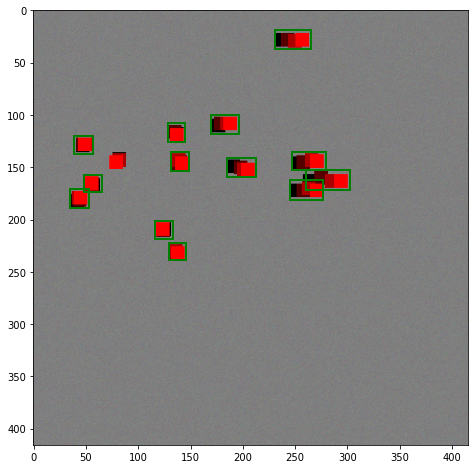

save! min_loss: 0.060201067477464676
Loop: 101 - Train loss: 0.049374, lr: 0.0002
Number of detections: 7


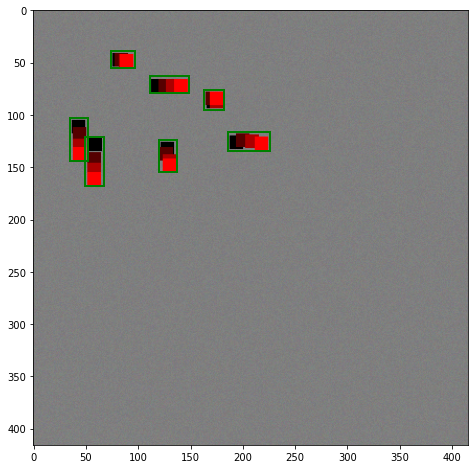

save! min_loss: 0.04937437575310469
Loop: 201 - Train loss: 0.048403, lr: 0.0002
Number of detections: 8


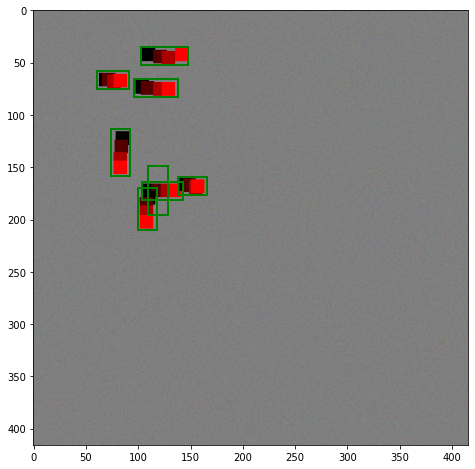

save! min_loss: 0.04840272359549999
Loop: 301 - Train loss: 0.048488, lr: 0.0002
Number of detections: 15


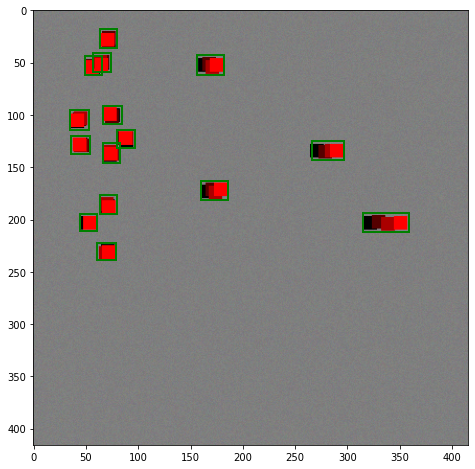

Loop: 401 - Train loss: 0.048132, lr: 0.0002
Number of detections: 6


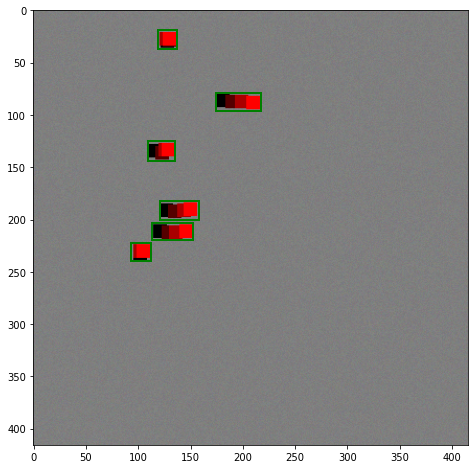

save! min_loss: 0.048131876736879346
Loop: 501 - Train loss: 0.047666, lr: 0.0002
Number of detections: 8


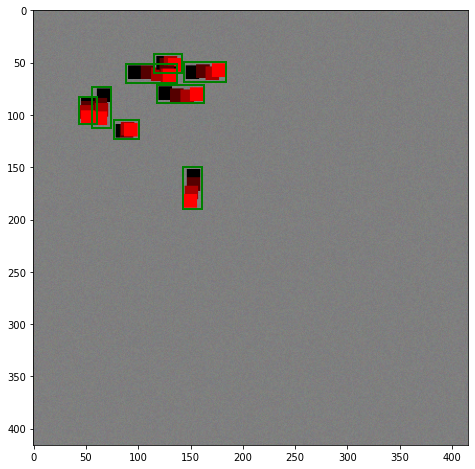

save! min_loss: 0.04766616359353065
Loop: 601 - Train loss: 0.046581, lr: 0.0002
Number of detections: 11


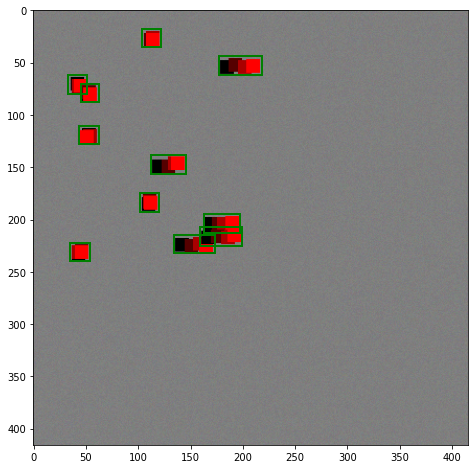

save! min_loss: 0.04658053819090128
Loop: 701 - Train loss: 0.046124, lr: 0.0002
Number of detections: 8


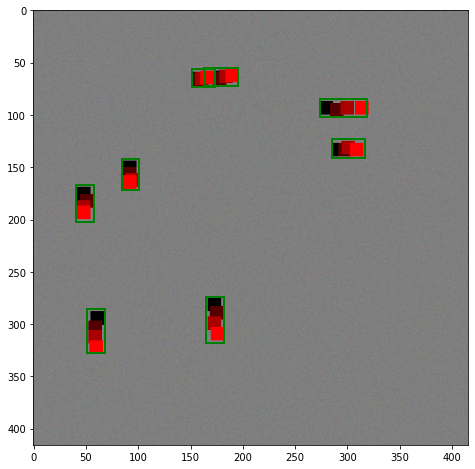

save! min_loss: 0.04612440165132284
Loop: 801 - Train loss: 0.047633, lr: 0.0002
Number of detections: 11


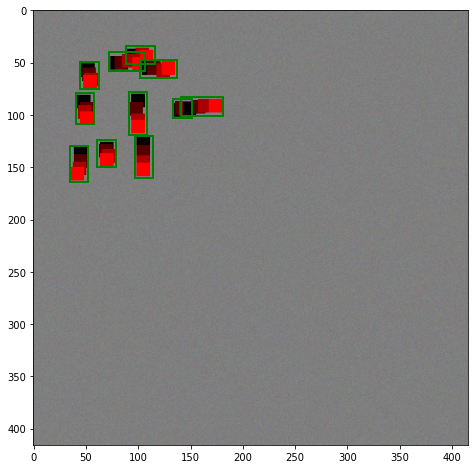

Loop: 901 - Train loss: 0.046260, lr: 0.0002
Number of detections: 7


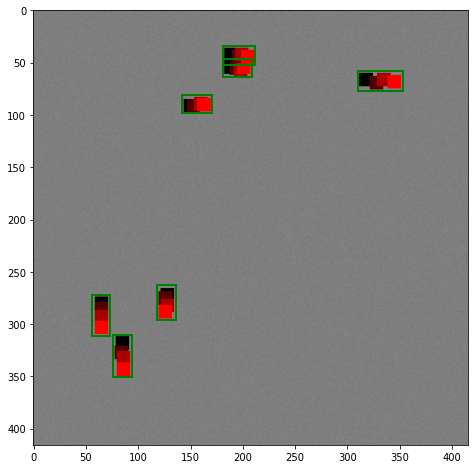

Loop: 1001 - Train loss: 0.045707, lr: 0.0002
Number of detections: 15


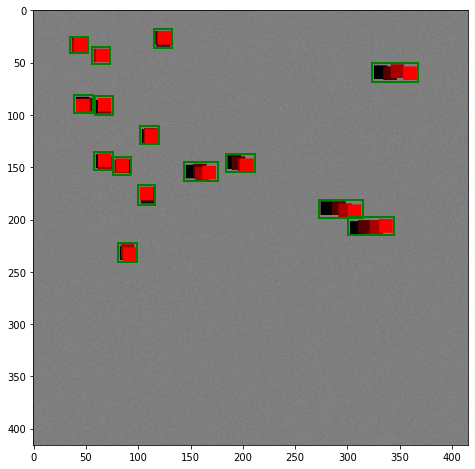

save! min_loss: 0.04570714183151722
Loop: 1101 - Train loss: 0.045042, lr: 0.0002
Number of detections: 14


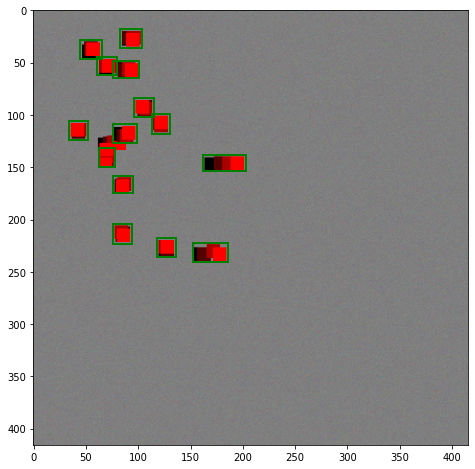

save! min_loss: 0.045041805170476436
Loop: 1201 - Train loss: 0.044011, lr: 0.0002
Number of detections: 5


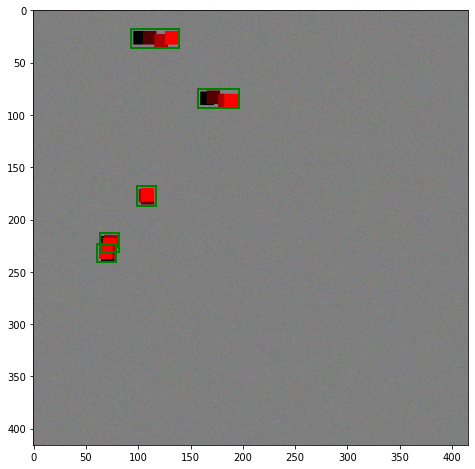

save! min_loss: 0.04401143979281187
Loop: 1301 - Train loss: 0.044630, lr: 0.0002
Number of detections: 13


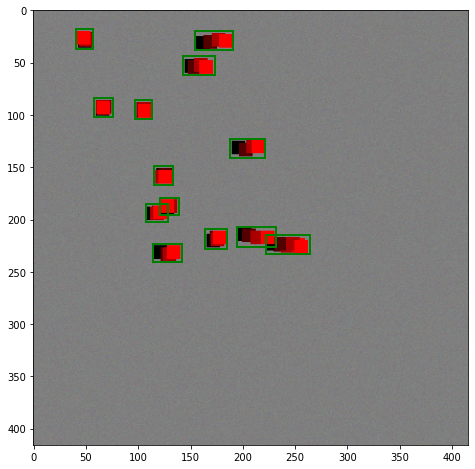

Loop: 1401 - Train loss: 0.043888, lr: 0.0002
Number of detections: 11


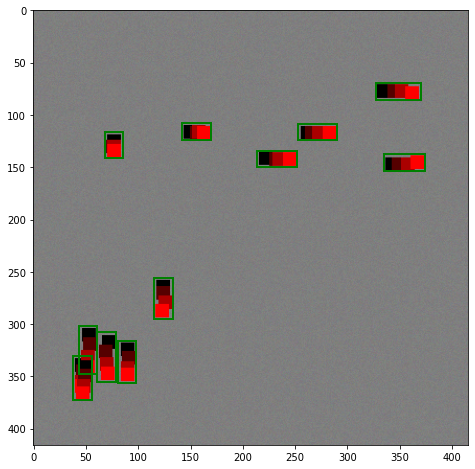

save! min_loss: 0.04388751771301031
Loop: 1501 - Train loss: 0.044793, lr: 0.0002
Number of detections: 7


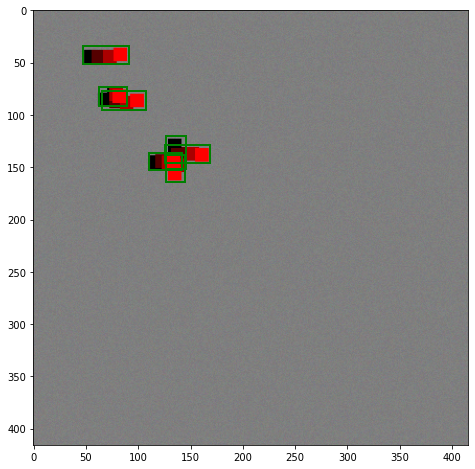

Loop: 1601 - Train loss: 0.042693, lr: 0.0002
Number of detections: 16


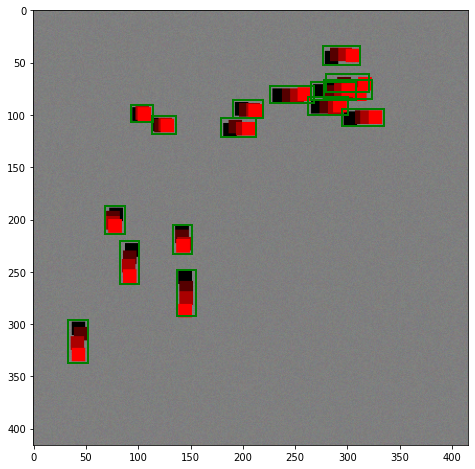

save! min_loss: 0.0426929547265172
Loop: 1701 - Train loss: 0.043738, lr: 0.0002
Number of detections: 12


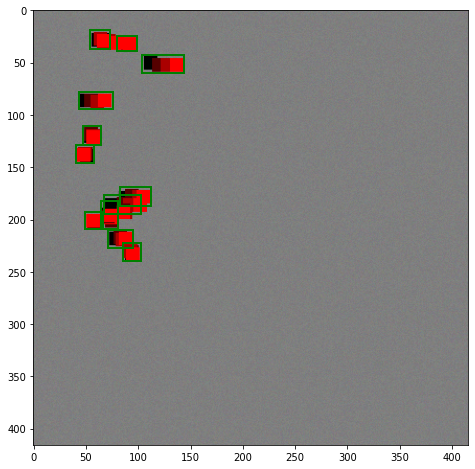

Loop: 1801 - Train loss: 0.043491, lr: 0.0002
Number of detections: 5


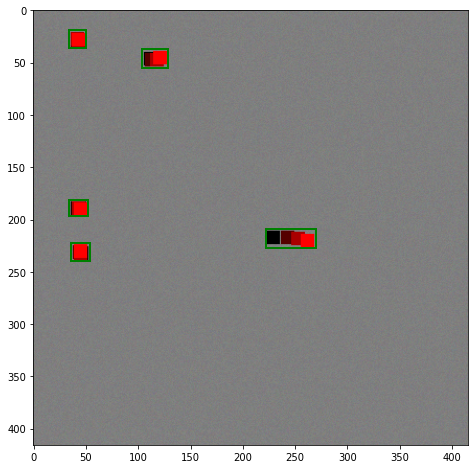

Loop: 1901 - Train loss: 0.043828, lr: 0.0002
Number of detections: 7


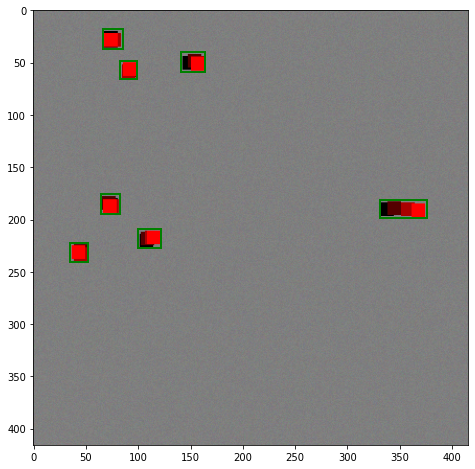

Loop: 2001 - Train loss: 0.041873, lr: 0.0002
Number of detections: 11


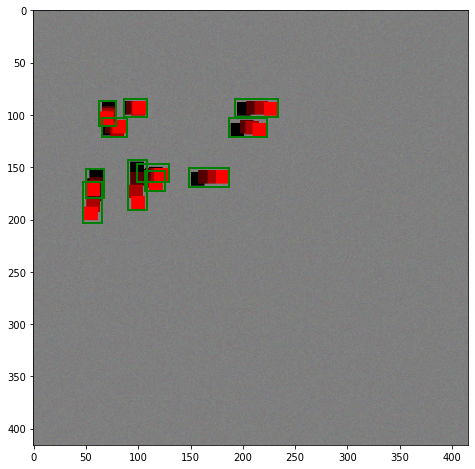

save! min_loss: 0.041873374320566654



In [ ]:
if 'model' in locals():
    del model
if 'checkpoint' in locals():
    del checkpoint

NUM_ITER = 2001
LEARNING_RATE = 0.0002
BATCH_SIZE = 16
SHED_GAMMA = 1  # 0.98
W_DECAY = 0  # 0.0001

model = Darknet(CFG_FILE).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=W_DECAY)

if LOAD:
    checkpoint = torch.load(LOADFILE)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    model.apply(weights_init_normal)

model, optimizer = train(model, optimizer, compute_loss, 
                         schedule_gamma=SHED_GAMMA, batch_size=BATCH_SIZE, num_iter=NUM_ITER, savefile=SAVEFILE)